In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import datetime as dt
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

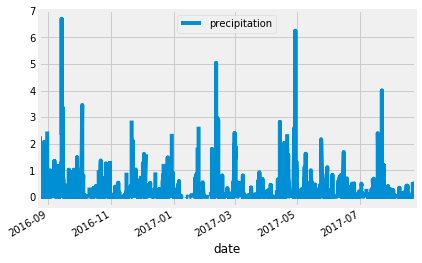

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

max_date = max_date[0]

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precipitation['date'] = pd.to_datetime(precipitation['date'], format='%Y-%m-%d')

# Set index to date
precipitation.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation = precipitation.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation.plot()
plt.legend(loc='upper center')
plt.savefig("Images/Precipitation.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).group_by(Station.station).count()
stations

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
max = session.query(func.max(Measurement.tobs)).all()
min = session.query(func.min(Measurement.tobs)).all()
avg = session.query(func.avg(Measurement.tobs)).all()

print(min, max, avg)

[(53.0,)] [(87.0,)] [(73.09795396419437,)]


In [ ]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])

# We need 12 bins since the observation is for twelve months
temperature_observations.plot.hist(bins=12)
plt.tight_layout()
plt.savefig("Images/StationAnalysis.png")
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Calculate date 1 year ago
endDate = dt.date(2017, 6 ,10)
Newyear_ago = endDate - dt.timedelta(days=365)
#print("Date year ago: ", Newyear_ago)

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-06-10', '2016-06-30'))


[(69.0, 76.1970802919708, 81.0)]


C:\Users\NithyaWindows\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


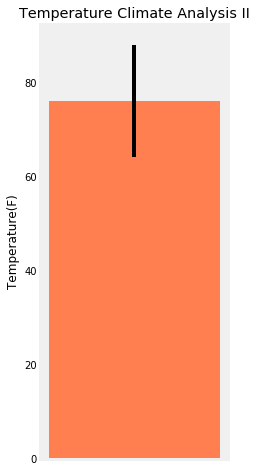

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax = 81
tmin = 69
tavg = 76.1970802919708
difftemp = tmax - tmin

plt.figure(figsize=(3, 8))
plt.tick_params(bottom='False', top='False', labelbottom='False')
plt.bar(1, tavg, yerr=difftemp, color='coral')
plt.ylabel('Temperature(F)')
plt.title('Temperature Climate Analysis II')
plt.savefig("Images/Temperature_Climate_Analysis.png")
plt.grid()
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

endDate = dt.date(2016, 6 ,10)
year_ago2 = endDate - dt.timedelta(days=365)

sel = [Measurement.station, Measurement.prcp, Station.name, Station.longitude, Station.latitude, Station.elevation]

rainfall_data = session.query(*sel).\
    filter(Measurement.date <= endDate).\
    filter(Measurement.date >= year_ago2).\
    group_by(Station.name).\
    order_by(Measurement.prcp).all()

rainfall_data

[('USC00519397',
  0.0,
  'HONOLULU OBSERVATORY 702.2, HI US',
  -157.9992,
  21.3152,
  0.9),
 ('USC00519397', 0.0, 'KANEOHE 838.1, HI US', -157.8015, 21.4234, 14.6),
 ('USC00519397',
  0.0,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  -157.8374,
  21.5213,
  7.0),
 ('USC00519397',
  0.0,
  'MANOA LYON ARBO 785.2, HI US',
  -157.8025,
  21.3331,
  152.4),
 ('USC00519397', 0.0, 'PEARL CITY, HI US', -157.9751, 21.3934, 11.9),
 ('USC00519397', 0.0, 'UPPER WAHIAWA 874.3, HI US', -158.0111, 21.4992, 306.6),
 ('USC00519397',
  0.0,
  'WAIHEE 837.5, HI US',
  -157.84888999999998,
  21.45167,
  32.9),
 ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0),
 ('USC00519397',
  0.0,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  -157.71139,
  21.33556,
  19.5)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
